# GreenRivers MORO

_Description_

In [1]:
# Import every package we need

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

Let's first import the random policies scenarios to look at our entire input-output space.

In [19]:
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     experiments, outcomes = evaluator.perform_experiments(
#         scenarios = 10,
#         policies = 4,
#     )

In [20]:
from ema_workbench.util.utilities import (save_results, load_results)

results = load_results('outcomes/400Scenarios75Policies.csv')

[MainProcess/INFO] results loaded succesfully from /Users/jrwang/Documents/Coding/Model-based-decision-making/outcomes/400Scenarios75Policies.csv


We need to get a sense of the expected outcomes from the outcomes to determine convergence later. Let's take a look at the outcomes of a few randomly sampled policies and scenarios here.

In [21]:
# Visualisations

## Set up MORO

_Why?_

|Outcome of interest| Expected Range  |
|-------------------|------------|
| Deaths            | $\leq$ 0.x|
| Damage            | $\leq$ 0.x |
| Evacuation Costs            | $\leq$ 0.x |
| Dike Investment Costs        | $\leq$ 0.x|   
| RfR Investment Costs         | $\geq$ 0.x|

In [3]:
# Initialize model parameters
from model.dike_model_function import DikeNetwork  # @UnresolvedImport
from model.problem_formulation import get_model_for_problem_formulation

dike_model, planning_steps = get_model_for_problem_formulation(5)

/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [4]:
# Define robustness functions

# Rebustness score
def robustness(data):
    ''' 
    Returns a robustness score for a value you want to minimize.
    s
    We want a function that returns 0 for the outcome to be in the range that we want and higher otherwise.
    
    Takes in an array and returns a score for each value of the same array.
    '''
    
    # Normalize
    mean = np.mean(data)
    iqr = sp.stats.iqr(data) + mean * 0.005 # Add a small number so the mean is still considered in the score rather than 0
    score = mean * iqr
    
    return score

def sumover_robustness(*data):
    '''
    Used to aggregate multiple outcomes into one robustness score.
    
    Input: multiple n-length (but same) arrays and sums up element-wise into a [1,n] array
    
    Returns: asks the robustness function to calculate a score for the [1,n] array.
    '''
    return robustness(sum(data))

# Initialize some vars to make `robustness_functions` a bit more read-able
var_list_damage = ['A.1_Expected Annual Damage 0','A.1_Expected Annual Damage 1','A.1_Expected Annual Damage 2',
                   'A.2_Expected Annual Damage 0','A.2_Expected Annual Damage 1','A.2_Expected Annual Damage 2',
                   'A.3_Expected Annual Damage 0','A.3_Expected Annual Damage 1','A.3_Expected Annual Damage 2',
                   'A.4_Expected Annual Damage 0','A.4_Expected Annual Damage 1','A.4_Expected Annual Damage 2',
                   'A.5_Expected Annual Damage 0','A.5_Expected Annual Damage 1','A.5_Expected Annual Damage 2']
var_list_deaths = ['A.1_Expected Number of Deaths 0','A.1_Expected Number of Deaths 1','A.1_Expected Number of Deaths 2',
                   'A.2_Expected Number of Deaths 0','A.2_Expected Number of Deaths 1','A.2_Expected Number of Deaths 2',
                   'A.3_Expected Number of Deaths 0','A.3_Expected Number of Deaths 1','A.3_Expected Number of Deaths 2',
                   'A.4_Expected Number of Deaths 0','A.4_Expected Number of Deaths 1','A.4_Expected Number of Deaths 2',
                   'A.5_Expected Number of Deaths 0','A.5_Expected Number of Deaths 1','A.5_Expected Number of Deaths 2']
var_list_dike = ['A.1_Dike Investment Costs 0','A.1_Dike Investment Costs 1','A.1_Dike Investment Costs 2',
                 'A.2_Dike Investment Costs 0','A.2_Dike Investment Costs 1','A.2_Dike Investment Costs 2',
                 'A.3_Dike Investment Costs 0','A.3_Dike Investment Costs 1','A.3_Dike Investment Costs 2',
                 'A.4_Dike Investment Costs 0','A.4_Dike Investment Costs 1','A.4_Dike Investment Costs 2',
                 'A.5_Dike Investment Costs 0','A.5_Dike Investment Costs 1','A.5_Dike Investment Costs 2']
var_list_rfr = ['RfR Total Costs 0', 'RfR Total Costs 1', 'RfR Total Costs 2']
var_list_evac = ['Expected Evacuation Costs 0', 'Expected Evacuation Costs 1', 'Expected Evacuation Costs 2']

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

# These functions need to only return one value...

robustness_functions = [
    ScalarOutcome('Damage Score', variable_name = var_list_damage, function = sumover_robustness, kind = MINIMIZE, expected_range=(0,4e16)),    
    ScalarOutcome('Deaths Score', variable_name = var_list_deaths, function = sumover_robustness, kind = MINIMIZE, expected_range=(0,8.5e19)),
    ScalarOutcome('Dike Invest Score', function = sumover_robustness, kind = MINIMIZE, variable_name = var_list_dike, expected_range=(1e18,1.3e7)),
    ScalarOutcome('RfR Invest Score', variable_name = var_list_rfr, function = sumover_robustness, kind = MINIMIZE, expected_range=(2e16,9.1e17)),
    ScalarOutcome('Evac Score', variable_name = var_list_evac, function = sumover_robustness, kind = MINIMIZE, expected_range=(0,2.5e12)),
]

In [28]:
from ema_workbench.em_framework import sample_uncertainties

n_scenarios = 2
scenarios = sample_uncertainties(dike_model, n_scenarios)
nfe = int(1001)

In [36]:
from ema_workbench import ema_logging
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

BaseEvaluator.reporting_frequency = 0.1
ema_logging.log_to_stderr(ema_logging.INFO)

epsilons = [0.05,]*len(robustness_functions)
convergence = [HyperVolume(minimum=[0,0,0,0,0], maximum=[1.1, 1.1, 1.1, 1.1, 1.1]),
              EpsilonProgress()]
# .from_outcomes(robustness_functions)
# (minimum=[0,0,0], maximum=[1.1, 1.1, 1.1])
start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robustness_functions,
                                                     scenarios = scenarios,
                                                     nfe=nfe,
                                                     epsilons=epsilons,
                                                     convergence=convergence,
                                                     convergence_freq =20,
                                                     logging_freq = 1
                                                    )

end = time.time()
print("Time taken: {:0.5f} minutes".format((end - start)/60))

[MainProcess/INFO] generation 0: 0/1001 nfe
[MainProcess/INFO] generation 1: 100/1001 nfe
[MainProcess/INFO] generation 2: 199/1001 nfe
[MainProcess/INFO] generation 3: 297/1001 nfe
[MainProcess/INFO] generation 4: 396/1001 nfe
[MainProcess/INFO] generation 5: 496/1001 nfe
[MainProcess/INFO] generation 6: 596/1001 nfe
[MainProcess/INFO] generation 7: 696/1001 nfe
[MainProcess/INFO] generation 8: 796/1001 nfe
[MainProcess/INFO] generation 9: 896/1001 nfe
[MainProcess/INFO] generation 10: 995/1001 nfe
[MainProcess/INFO] optimization completed, found 6 solutions


Time taken: 16.37699 minutes


In [37]:
results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Damage Score,Deaths Score,Dike Invest Score,RfR Invest Score,Evac Score
0,0,0,0,0,0,0,0,0,0,0,...,4,0,3,1,6,1.758735e+17,1.039154e-03,7.812765e+16,0.000000e+00,1.987931e+07
1,0,1,0,1,1,0,1,0,1,1,...,2,2,4,1,2,0.000000e+00,0.000000e+00,6.814163e+15,3.394880e+15,0.000000e+00
2,0,0,0,0,0,1,1,1,0,0,...,0,2,3,3,2,1.852917e+11,1.374449e-09,1.097585e+16,3.897632e+14,1.057901e+03
3,0,0,0,0,0,0,0,1,0,0,...,4,1,2,3,0,0.000000e+00,0.000000e+00,1.767522e+16,4.712450e+12,0.000000e+00
4,0,0,0,0,0,0,1,1,1,0,...,3,3,4,0,0,4.527644e+13,2.964301e-06,8.140035e+15,4.241205e+13,5.792983e+04
5,0,1,0,0,0,0,0,1,1,0,...,3,3,3,0,2,0.000000e+00,0.000000e+00,1.144199e+16,1.065800e+14,0.000000e+00


In [38]:
convergence

,hypervolume,epsilon_progress,nfe
0,0.0,0,0
1,0.0,21,100
2,0.0,27,199
3,0.0,31,297
4,0.0,38,396
5,0.0,47,496
6,0.0,56,596
7,0.0,68,696
8,0.0,76,796
9,0.0,83,896


## Evaluate $\epsilon$-convergence

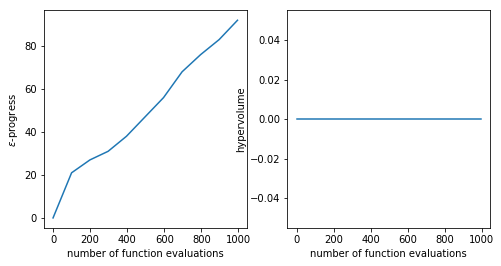

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

## Re-evaluate under more scenarios

In [ ]:
# policies = ??

In [ ]:
start = time.time()
with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(scenarios = 1000, policies = policies)
end = time.time()
print("Time taken: {:0.5f} minutes".format((end - start)/60))

We can also evaluate regret compared to a base case.

In [ ]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [ ]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

In [ ]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [ ]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

We see striking differences between blue and orange (1 and 3) and green and red (5 and 8). The first two options have low regret on the first three objectives, but higher regret on utility. For the second two options it is reversed

Note that we have been looking at the maximum regret. I also saved the distribution of regret over the set of scenarios. So let's visualize this and see what we can learn from it

In [ ]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

In [ ]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1],
        axes[1,0],]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()